<a href="https://colab.research.google.com/github/addejans/GANs-Generating-Images/blob/master/GANs_Project_2_Generate_New_Fashion_Images_Using_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM STATEMENT

We will generate new images that have never existed in the past.  We will use the Fashion MNIST Data Set.

### IMPORT LIBRARIES

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-beta1


     |████████████████████████████████| 348.9MB 44kB/s 
     |████████████████████████████████| 501kB 41.6MB/s 
     |████████████████████████████████| 3.1MB 41.3MB/s 


In [2]:

!pip install imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


import tensorflow as tf




/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### IMPORT DATASETS AND NORMALIZE IT

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [8]:
train_images.shape

(60000, 28, 28)

In [9]:
train_labels.shape

(60000,)

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')


In [11]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### VISUALIZE DATASET

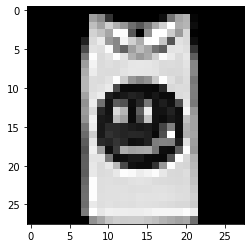

In [18]:
plt.imshow(train_images[101].reshape((28,28)) , cmap = 'gray')

### BUILD GENERATOR

- The generator takes in a random noise signal and output images.
- The generator is trying to generate fake images that are similar to the real images (ones that comes from the training data) 
- The objective of the generator is to fool the discriminator. 
- Labels are marked as follows: 
    - Label = 1.0 indicates real images
    - Label = 0.0 indicates fake images
- The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to create an image from a seed of noise.
- The seed is fed to a Dense layer and upsampled several times until the final image size of 28x28x1 is achieved.


In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Because we used "same" padding and stride = 1, the output is the same size as input 7 x 7 but with 128 filters instead
    # Resulting in 7 x 7 x 128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Because we used "same" padding and stride = 2, the output is double the size of the input 14 x 14 but with 64 filters instead
    # Resulting in 14 x 14 x 64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Because we used "same" padding and stride = 2, the output is double the size of the input 28 x 28 but with 1 filter instead
    # Resulting in 28 x 28 x 1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.summary()

    return model

In [20]:
# test and check the dimensions
generator = make_generator_model()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [21]:
# Test it with a random noise seed and see the output

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

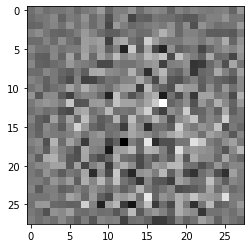

In [22]:

plt.imshow(generated_image[0,:,:,0], cmap='gray')

### BUILD THE DISCRIMINATOR

- The discriminator is a basic Neural Network that is trained to perform classification task
- The discriminator is trained to do the following: 
   - Output 0 (probability = 0%) when the input image is fake 
   - Output 1 (probability = 100%) when the input image is real


In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()

    return model

In [24]:
# View the model structure
discriminator = make_discriminator_model()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [27]:
# See if the discriminator was able to classify the image or not.
# The model will be trained to output positive values for real images, and negative values for fake images.
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00040427]], shape=(1, 1), dtype=float32)


#### DEFINE THE LOSS FUNCTIONS FOR BOTH NETWORKS

In [0]:
# This computes the "loss" which is simply the difference between the model predictions and the true label
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# The discriminator loss indicates how well the discriminator is able to distinguish real and fake images. 
# It compares the discriminator's predictions on real images to an array of 1s, 
# and the discriminator's predictions on fake (generated) images to an array of 0s.

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss # sum up both losses
    return total_loss

In [0]:
# The generator's loss quantifies how well it was able to trick the discriminator. 
# if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
# Here, we will compare the discriminators decisions on the generated images to an array of 1s.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### TRAIN THE MODEL 

In [0]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # step 1. call the generator and feed in the noise seed

      real_output = discriminator(images, training=True) # step 2. pass the fake and real ones to discriminator to perform classification
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output) # step 3. Calculate the loss for both the generator and discriminator
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

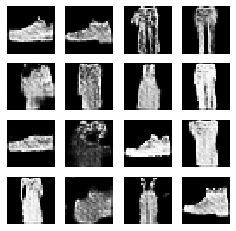

CPU times: user 8min 50s, sys: 1min 46s, total: 10min 37s
Wall time: 41min 26s


In [37]:
%%time
train(train_dataset, EPOCHS)

In [38]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

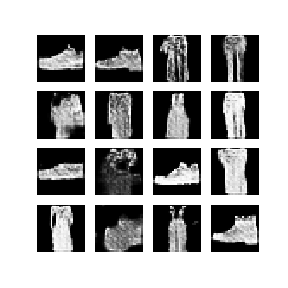

In [39]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)


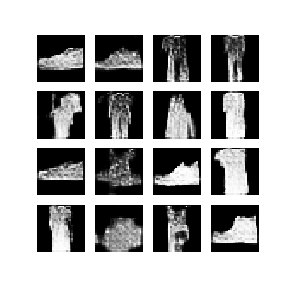

In [40]:
display_image(75)

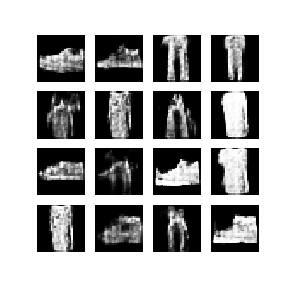

In [41]:
display_image(50)

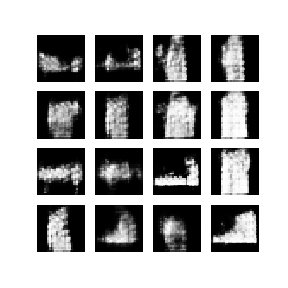

In [42]:
display_image(25)

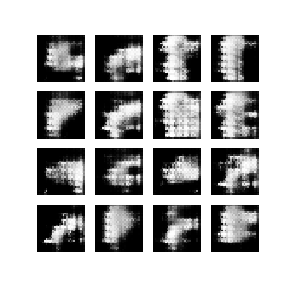

In [43]:
display_image(10)

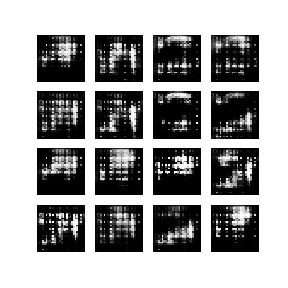

In [44]:
display_image(5)